In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [78]:
# FRED Data Loader Function
def load_fred_csv(path):
    df = pd.read_csv(path)
    # Set date
    df['date'] = pd.to_datetime(df['observation_date'])
    df = df.set_index('date')
    df = df.drop('observation_date', axis=1)
    return df

# Load FRED Price Data
beef = load_fred_csv("../data/PBEEFUSDM.csv")
corn = load_fred_csv("../data/PMAIZMTUSDM.csv")
pork = load_fred_csv("../data/PPORKUSDM.csv")
lamb = load_fred_csv("../data/PLAMBUSDM.csv")
chicken = load_fred_csv("../data/PPOULTUSDM.csv")
oil = load_fred_csv("../data/POILBREUSDM.csv")
usd = load_fred_csv("../data/RTWEXBGS_PCH.csv")

# US Drought Data
us_drought = pd.read_csv("../data/us_drought.csv")
date_col = "Month"
us_drought[date_col] = pd.to_datetime(us_drought[date_col])
us_drought = us_drought.set_index(date_col)
us_drought.index = us_drought.index.to_period("M").to_timestamp(how="start")
us_drought = us_drought.sort_index()
us_drought = us_drought[~us_drought.index.duplicated(keep="first")]

# Remove 'None' column and rename D0-D4 to include USA suffix
drought_columns = ['D0', 'D1', 'D2', 'D3', 'D4']
if 'None' in us_drought.columns:
    us_drought = us_drought.drop(columns=['None'])
us_drought[drought_columns] = us_drought[drought_columns].fillna(0)
us_drought = us_drought.rename(columns={
    'D0': 'D0_USA',
    'D1': 'D1_USA',
    'D2': 'D2_USA',
    'D3': 'D3_USA',
    'D4': 'D4_USA'
})

# Brazil Drought Data
brazil_drought = pd.read_csv("../data/brazil_drought.csv")
brazil_drought["date"] = pd.to_datetime(brazil_drought["date"])
brazil_drought = brazil_drought.set_index("date")

# Rename Brazil drought columns and drop cwd_BR
if 'cdd' in brazil_drought.columns:
    brazil_drought = brazil_drought.rename(columns={'cdd': 'cdd_BR'})
if 'pr' in brazil_drought.columns:
    brazil_drought = brazil_drought.rename(columns={'pr': 'precip_BR'})
if 'cwd' in brazil_drought.columns:
    brazil_drought = brazil_drought.drop(columns=['cwd'])

# ENSO Data
enso = pd.read_csv("../data/ncep_noaa_seatemp.txt",
                   sep='\\s+',
                   names=["YR","MON","TOTAL","ClimAdjust","ANOM"],
                   comment="#",
                   skiprows=1)
enso['date'] = pd.to_datetime(dict(year=enso.YR, month=enso.MON, day=1))
enso = enso.set_index('date')
enso = enso[['ANOM']].rename(columns={'ANOM': 'enso_anomaly'})

In [79]:
# FAO Food Price Index - Load from CSV
food_index = pd.read_csv("../data/food_price_index.csv", sep=';')
# Keep only the first two columns (Date and Food Price Index) and drop the rest
food_index = food_index.iloc[:, :2]
food_index.columns = ['date', 'fao_food_index']
food_index['date'] = pd.to_datetime(food_index['date'], format='%Y-%m', errors='coerce')
food_index = food_index.dropna(subset=['date'])
food_index = food_index.set_index('date')
food_index.index = food_index.index.to_period("M").to_timestamp(how="start")
food_index = food_index[~food_index.index.duplicated(keep="first")]

In [80]:
# Bioethanol Production #
bioethanol = pd.read_csv("../data/bioethanolproduction.csv", sep=';', skipinitialspace=True)
bioethanol.columns = bioethanol.columns.str.strip()
# Parse date and value columns properly
date_col = bioethanol.columns[0]
value_col = bioethanol.columns[1]
bioethanol['date'] = pd.to_datetime(bioethanol[date_col], format='%b-%Y', errors='coerce')
bioethanol[value_col] = pd.to_numeric(bioethanol[value_col], errors='coerce')
# Rename the long column name to something shorter for easier reference
bioethanol = bioethanol[[value_col, 'date']].rename(columns={value_col: 'bioethanol_production'})
bioethanol = bioethanol.set_index('date')
bioethanol = bioethanol[~bioethanol.index.duplicated(keep='first')]

In [81]:
# China Retail Sales (divide by 1 million to scale down)
china_retail = pd.read_csv("../data/china_retail_sales_nominal.csv")
china_retail['Date'] = pd.to_datetime(china_retail['Date'], errors='coerce')
china_retail['Retail_Sales_nominal'] = pd.to_numeric(china_retail['Retail_Sales_nominal'], errors='coerce')
# Scale down by dividing by 1 million
china_retail['retail_china'] = china_retail['Retail_Sales_nominal'] / 1_000_000
china_retail = china_retail[['Date', 'retail_china']].rename(columns={'Date': 'date'})
china_retail = china_retail.set_index('date')
china_retail = china_retail[~china_retail.index.duplicated(keep='first')]

# USA Food & Beverage Retail Sales
fnb_retail = pd.read_csv("../data/retail_sales.csv")
fnb_retail['observation_date'] = pd.to_datetime(fnb_retail['observation_date'], errors='coerce')
fnb_retail['retail_sale_food_service_drinking_place'] = pd.to_numeric(fnb_retail['retail_sale_food_service_drinking_place'], errors='coerce')
fnb_retail = fnb_retail[['observation_date', 'retail_sale_food_service_drinking_place']].rename(
    columns={'observation_date': 'date', 'retail_sale_food_service_drinking_place': 'fnbretail_USA'}
)
fnb_retail = fnb_retail.set_index('date')
fnb_retail = fnb_retail[~fnb_retail.index.duplicated(keep='first')]

In [82]:
df = (corn
      .join(beef, how="outer")
      .join(pork, how="outer")
      .join(lamb, how="outer")
      .join(chicken, how="outer")
      .join(oil, how="outer")
      #.join(usd, how="outer") 
      .join(food_index, how="outer")
      .join(bioethanol, how="outer")
      .join(china_retail, how="outer")
      .join(fnb_retail, how="outer")
      .join(us_drought, how="outer")
      .join(brazil_drought, how="outer")
      .join(enso, how="outer")
     )

In [83]:
# Sort by date and clean the data
df = df.sort_index()

# Drop rows with any NaN values
df = df.dropna()

# Find the longest continuous segment (consecutive months without gaps)
# Convert index to periods to detect month-to-month continuity
index_as_periods = df.index.to_period('M')

# Calculate the difference in months between consecutive periods
diff_in_months_series = pd.Series(index_as_periods).diff().apply(lambda x: x.n if pd.notna(x) else 0).values

# Identify segments (where difference != 1, there's a gap)
segments = (diff_in_months_series != 1).cumsum()

# Find the longest segment
unique, counts = np.unique(segments, return_counts=True)
longest_segment = unique[np.argmax(counts)]

# Filter to longest segment
df_clean = df[segments == longest_segment].copy()

print(f"Original joined df shape: {df.shape}")
print(f"After removing NaN values: {df.shape}")
print(f"Longest continuous segment shape: {df_clean.shape}")
print(f"Date range of df_clean: {df_clean.index[0]} to {df_clean.index[-1]}")
print(f"Columns in df_clean: {list(df_clean.columns)}")

Original joined df shape: (242, 18)
After removing NaN values: (242, 18)
Longest continuous segment shape: (242, 18)
Date range of df_clean: 2002-11-01 00:00:00 to 2022-12-01 00:00:00
Columns in df_clean: ['PMAIZMTUSDM', 'PBEEFUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'bioethanol_production', 'retail_china', 'fnbretail_USA', 'D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA', 'cdd_BR', 'precip_BR', 'enso_anomaly']


## EDA & Pre-processing

Summary Statistics for df_clean:


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,bioethanol_production,retail_china,fnbretail_USA,D0_USA,D1_USA,D2_USA,D3_USA,D4_USA,cdd_BR,precip_BR,enso_anomaly
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,2.420000e+02,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,188.316069,168.389331,72.104522,134.927993,101.695594,71.249873,99.988843,751.706612,1.933260e+06,46494.847107,17.014174,10.885000,8.215785,4.889793,1.705785,10.222603,147.000702,-0.085537
std,67.223973,48.349486,16.821360,26.345812,29.969954,27.102952,23.752042,304.287701,1.163976e+06,13859.686901,4.975288,3.816214,4.850147,4.026209,2.160655,5.984585,73.263905,0.833040
min,93.415148,78.250000,40.602105,86.119095,61.488636,24.250476,55.900000,166.000000,3.535200e+05,27058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.380000,33.160000,-1.690000
25%,150.702291,119.700000,58.957083,110.918264,80.799513,50.412490,86.775000,487.500000,8.127900e+05,36514.500000,13.440000,8.155000,4.472500,1.277500,0.060000,4.782500,71.082500,-0.700000
50%,166.708197,180.114130,69.867857,140.139116,94.610795,66.560227,96.950000,891.000000,1.834750e+06,42928.000000,17.505000,11.005000,7.440000,4.300000,0.960000,8.310000,149.900000,-0.175000
75%,235.567209,195.421690,81.280574,155.711640,114.214109,93.471769,120.775000,994.500000,3.019950e+06,56118.250000,20.900000,13.365000,11.265000,7.942500,2.447500,15.535000,212.805000,0.447500
max,348.507117,275.304348,128.667727,186.588721,227.963324,133.585217,160.200000,1089.000000,4.126900e+06,83665.000000,29.690000,22.080000,22.270000,16.100000,9.970000,23.340000,288.100000,2.710000



Visualizing US Drought Severities:


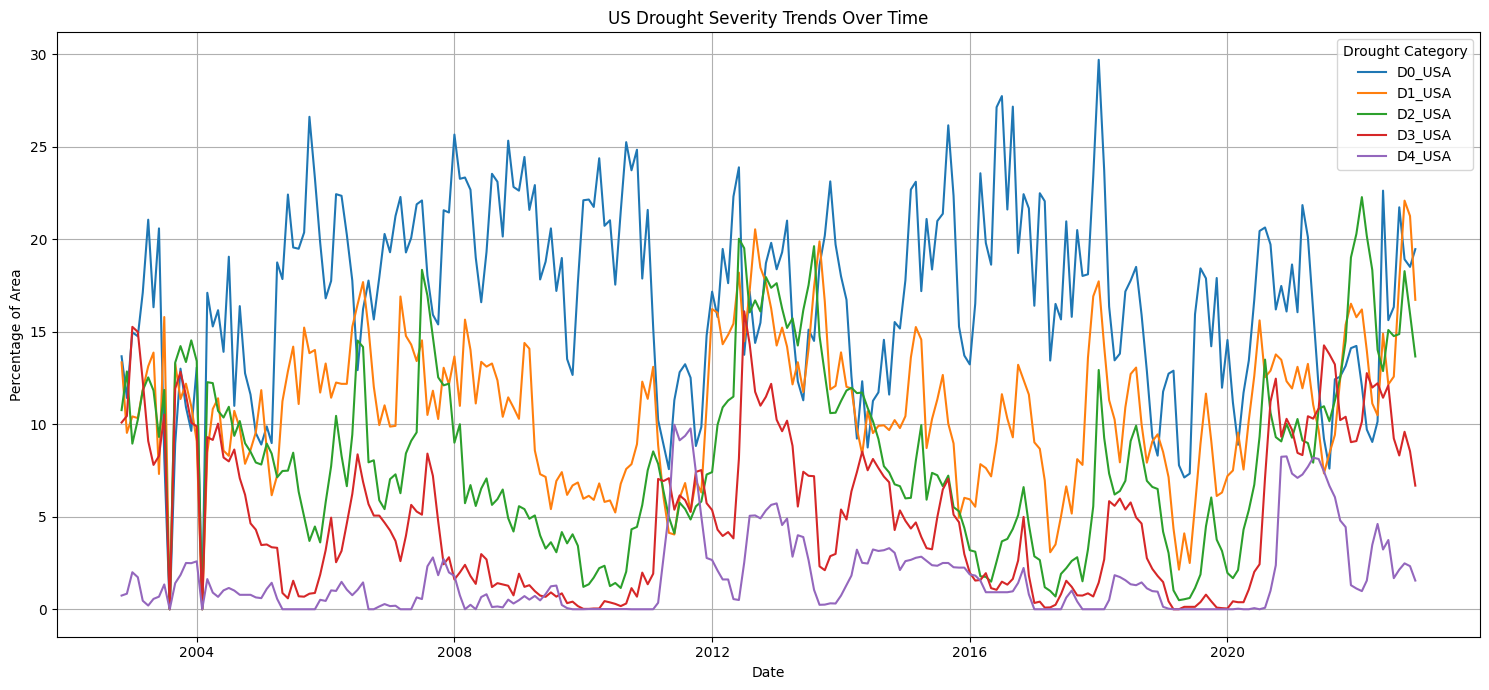

In [84]:
print("Summary Statistics for df_clean:")
display(df_clean.describe())

print("\nVisualizing US Drought Severities:")
drought_cols = ['D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA']

plt.figure(figsize=(15, 7))
for col in drought_cols:
    plt.plot(df_clean.index, df_clean[col], label=col)

plt.title('US Drought Severity Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Area')
plt.legend(title='Drought Category')
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
# ADF Test for stationarity of all variables #
# Test ALL variables in the dataset, not just prices
all_variables = df_clean.columns.tolist()
print(f"Variables to test: {all_variables}")

Variables to test: ['PMAIZMTUSDM', 'PBEEFUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'bioethanol_production', 'retail_china', 'fnbretail_USA', 'D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA', 'cdd_BR', 'precip_BR', 'enso_anomaly']


In [87]:
def run_adf_test(series, variable_name):
    """Perform ADF test on a series and return results"""
    if series.isnull().any():
        series = series.dropna()
    
    if len(series) < 5:
        print(f"Warning: {variable_name} has too few observations ({len(series)}) for ADF test. Skipping.")
        return None
    
    try:
        adf_result = adfuller(series, autolag='AIC')
        return {
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'critical_values': adf_result[4]
        }
    except Exception as e:
        print(f"Error testing {variable_name}: {e}")
        return None

# Perform ADF test on all variables
print(f"\n{'='*70}")
print(f"ADF Stationarity Test Results for All Variables")
print(f"{'='*70}\n")

for variable in all_variables:
    series = df_clean[variable].astype(float)
    result = run_adf_test(series, variable)
    
    if result:
        stationary = "YES" if result['p_value'] <= 0.05 else "NO"
        print(f"{variable:25} | ADF Stat: {result['adf_statistic']:8.4f} | p-value: {result['p_value']:.6f} | Stationary: {stationary}")


ADF Stationarity Test Results for All Variables

PMAIZMTUSDM               | ADF Stat:  -1.8987 | p-value: 0.332657 | Stationary: NO
PBEEFUSDM                 | ADF Stat:  -1.8219 | p-value: 0.369656 | Stationary: NO
PPORKUSDM                 | ADF Stat:  -4.5673 | p-value: 0.000148 | Stationary: YES
PLAMBUSDM                 | ADF Stat:  -2.4664 | p-value: 0.123867 | Stationary: NO
PPOULTUSDM                | ADF Stat:  -0.7545 | p-value: 0.832120 | Stationary: NO
POILBREUSDM               | ADF Stat:  -2.8936 | p-value: 0.046100 | Stationary: YES
fao_food_index            | ADF Stat:  -2.1282 | p-value: 0.233322 | Stationary: NO
bioethanol_production     | ADF Stat:  -2.1265 | p-value: 0.234011 | Stationary: NO
retail_china              | ADF Stat:  -0.0333 | p-value: 0.955693 | Stationary: NO
fnbretail_USA             | ADF Stat:   1.0146 | p-value: 0.994418 | Stationary: NO
D0_USA                    | ADF Stat:  -6.7562 | p-value: 0.000000 | Stationary: YES
D1_USA                 

In [88]:
# Create comprehensive ADF summary table for all variables
adf_summary = []

for variable in all_variables:
    series = df_clean[variable].astype(float)
    
    if series.isnull().any():
        series = series.dropna()
    
    if len(series) < 5:
        continue
    
    try:
        adf_result = adfuller(series, autolag='AIC')
        adf_statistic = adf_result[0]
        p_value = adf_result[1]
        critical_1pct = adf_result[4]['1%']
        critical_5pct = adf_result[4]['5%']
        critical_10pct = adf_result[4]['10%']
        stationary = 'Stationary' if p_value <= 0.05 else 'Non-stationary'
        
        adf_summary.append({
            'Variable': variable,
            'ADF Statistic': round(adf_statistic, 4),
            'P-value': round(p_value, 6),
            'Critical 1%': round(critical_1pct, 4),
            'Critical 5%': round(critical_5pct, 4),
            'Critical 10%': round(critical_10pct, 4),
            'Stationary': stationary
        })
    except Exception as e:
        print(f"Error for {variable}: {e}")

# Create and display summary DataFrame
adf_summary_df = pd.DataFrame(adf_summary)
print("\n" + "="*100)
print("ADF STATIONARITY TEST SUMMARY")
print("="*100)
display(adf_summary_df)


ADF STATIONARITY TEST SUMMARY


,Variable,ADF Statistic,P-value,Critical 1%,Critical 5%,Critical 10%,Stationary
0,PMAIZMTUSDM,-1.8987,0.332657,-3.4579,-2.8737,-2.5732,Non-stationary
1,PBEEFUSDM,-1.8219,0.369656,-3.4582,-2.8738,-2.5733,Non-stationary
2,PPORKUSDM,-4.5673,0.000148,-3.4579,-2.8737,-2.5732,Stationary
3,PLAMBUSDM,-2.4664,0.123867,-3.4581,-2.8738,-2.5733,Non-stationary
4,PPOULTUSDM,-0.7545,0.832120,-3.4596,-2.8744,-2.5736,Non-stationary
5,POILBREUSDM,-2.8936,0.046100,-3.4579,-2.8737,-2.5732,Stationary
6,fao_food_index,-2.1282,0.233322,-3.4579,-2.8737,-2.5732,Non-stationary
7,bioethanol_production,-2.1265,0.234011,-3.4594,-2.8743,-2.5736,Non-stationary
8,retail_china,-0.0333,0.955693,-3.4596,-2.8744,-2.5736,Non-stationary
9,fnbretail_USA,1.0146,0.994418,-3.4595,-2.8744,-2.5736,Non-stationary


## Fractional Differencing (Lopez de Prado, 2018)

Apply fixed-width window fractional differencing only to non-stationary series. Stationary series are kept in levels.


ACF ANALYSIS FOR NON-STATIONARY VARIABLES

Non-stationary variables requiring transformation:
  - PMAIZMTUSDM
  - PBEEFUSDM
  - PLAMBUSDM
  - PPOULTUSDM
  - fao_food_index
  - bioethanol_production
  - retail_china
  - fnbretail_USA


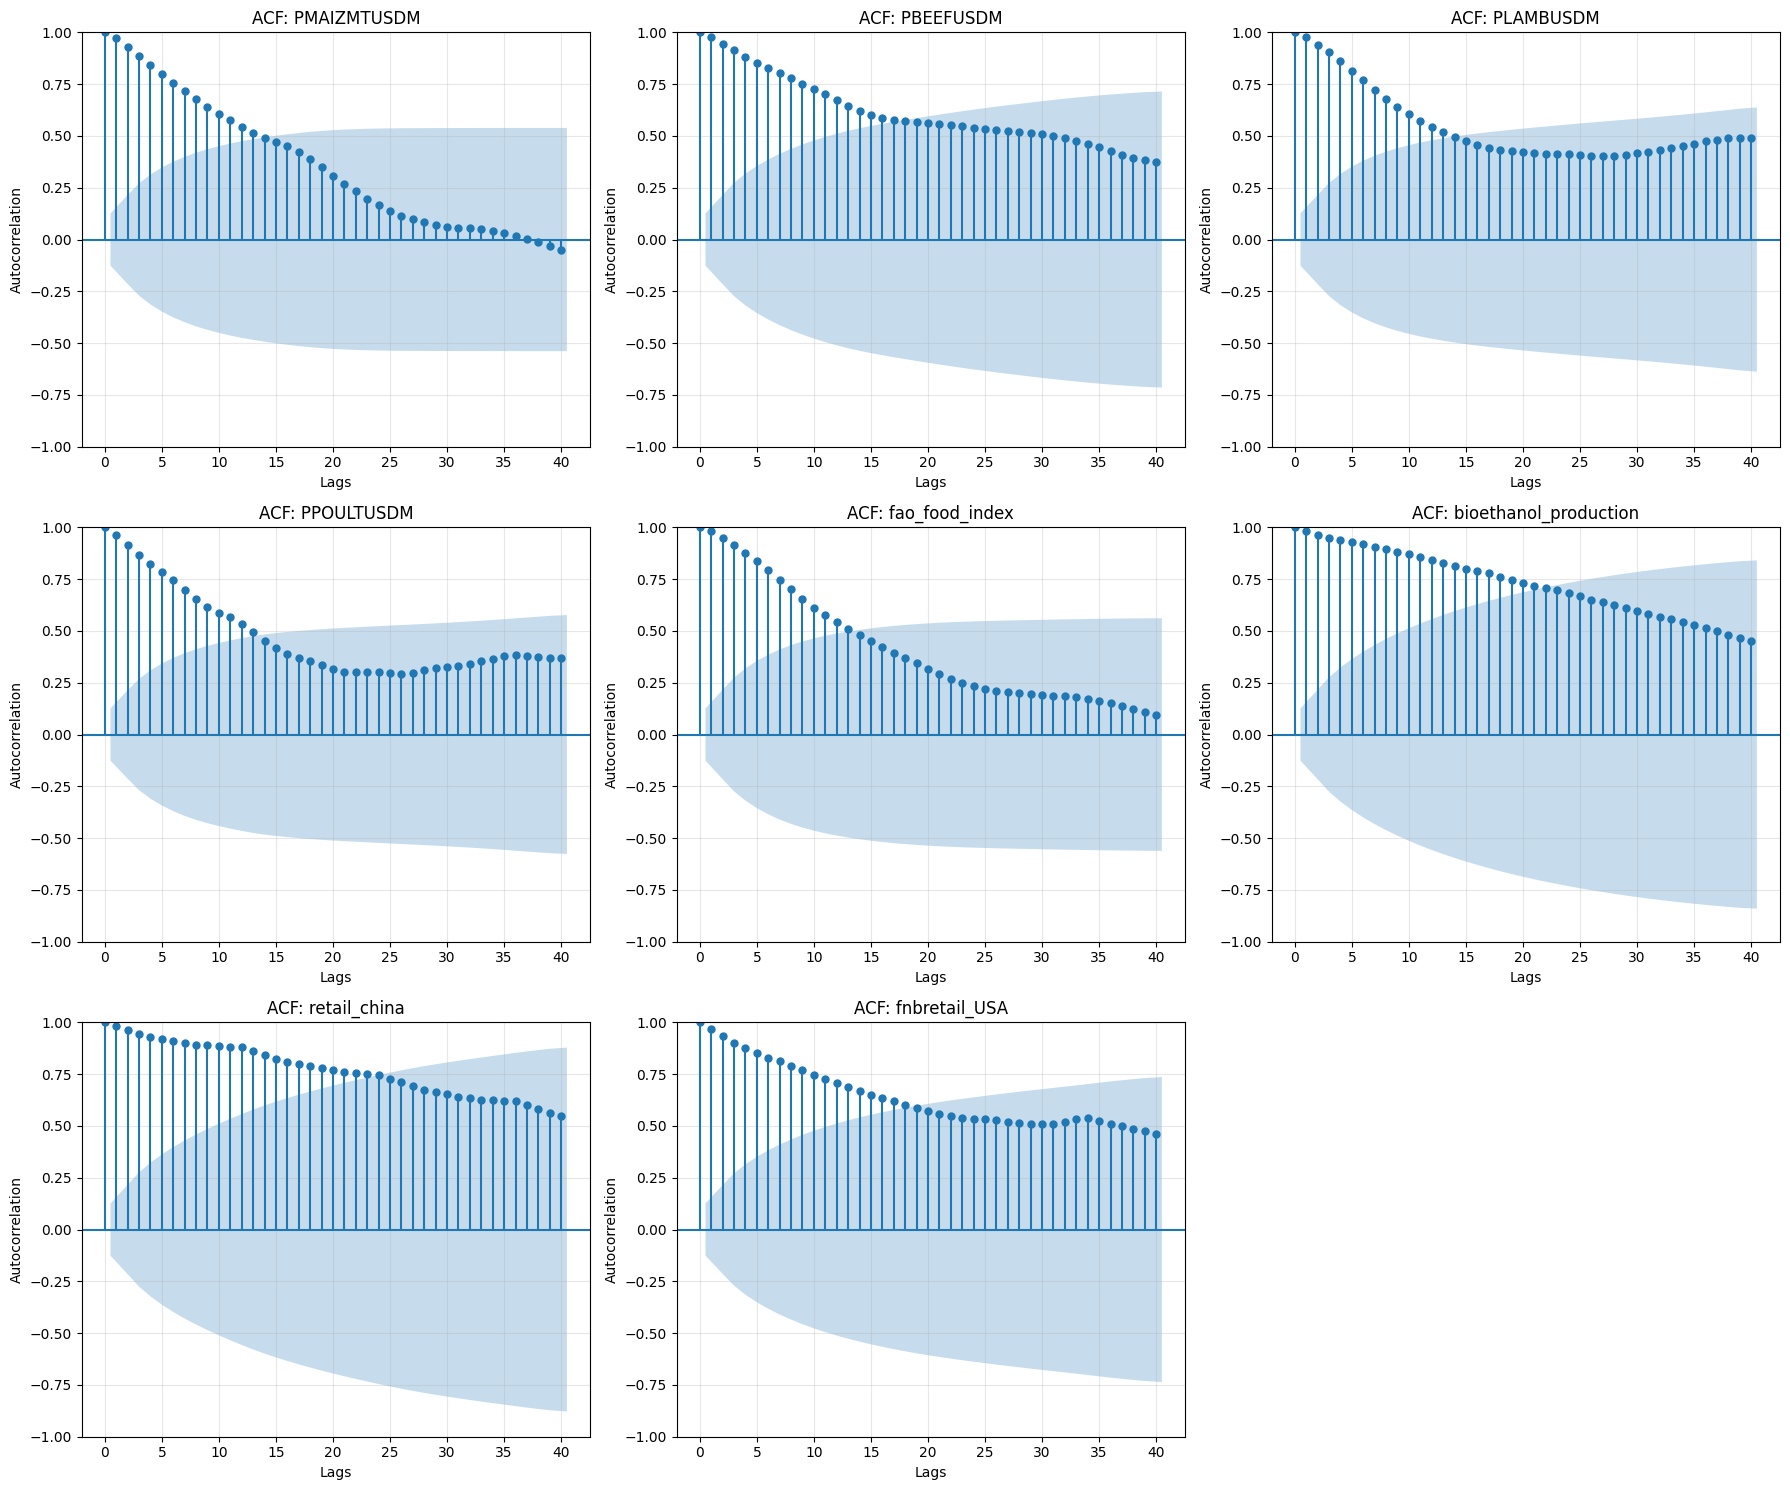


INTERPRETATION

The ACF plots above show strong autocorrelation at multiple lags for non-stationary variables.

Key observations:
1. SLOW DECAY: ACF values decay very slowly, indicating strong persistence
2. LONG MEMORY: Autocorrelation remains significant even at high lags (20+)
3. UNIT ROOT CHARACTERISTIC: This slow decay pattern is characteristic of I(1) processes
4. DIFFERENCING NEEDED: Traditional integer differencing (d=1) would over-difference
   
Why Fractional Differencing (Lopez de Prado):
- Preserves MEMORY while achieving STATIONARITY
- Integer differencing (d=1) removes too much information
- Fractional differencing (0 < d < 1) uses optimal memory preservation
- Weights recent observations more heavily, maintaining useful autocorrelation structure



In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create ACF plots for non-stationary variables to justify fractional differencing
non_stationary_vars = adf_summary_df[adf_summary_df['Stationary'] == 'Non-stationary']['Variable'].tolist()

print(f"\n{'='*100}")
print(f"ACF ANALYSIS FOR NON-STATIONARY VARIABLES")
print(f"{'='*100}")
print(f"\nNon-stationary variables requiring transformation:")
for var in non_stationary_vars:
    print(f"  - {var}")

# Create ACF plots for non-stationary variables
num_vars = len(non_stationary_vars)
rows = int(np.ceil(num_vars / 3))
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten() if num_vars > 1 else [axes]

for idx, variable in enumerate(non_stationary_vars):
    series = df_clean[variable].astype(float).dropna()
    
    # Plot ACF
    plot_acf(series, lags=40, ax=axes[idx], title=f'ACF: {variable}', alpha=0.05)
    axes[idx].set_xlabel('Lags')
    axes[idx].set_ylabel('Autocorrelation')
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_vars, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)
print("""
The ACF plots above show strong autocorrelation at multiple lags for non-stationary variables.

Key observations:
1. SLOW DECAY: ACF values decay very slowly, indicating strong persistence
2. LONG MEMORY: Autocorrelation remains significant even at high lags (20+)
3. UNIT ROOT CHARACTERISTIC: This slow decay pattern is characteristic of I(1) processes
4. DIFFERENCING NEEDED: Traditional integer differencing (d=1) would over-difference
   
Why Fractional Differencing (Lopez de Prado):
- Preserves MEMORY while achieving STATIONARITY
- Integer differencing (d=1) removes too much information
- Fractional differencing (0 < d < 1) uses optimal memory preservation
- Weights recent observations more heavily, maintaining useful autocorrelation structure
""")



SCATTER PLOTS: ORIGINAL DATA (df_clean)


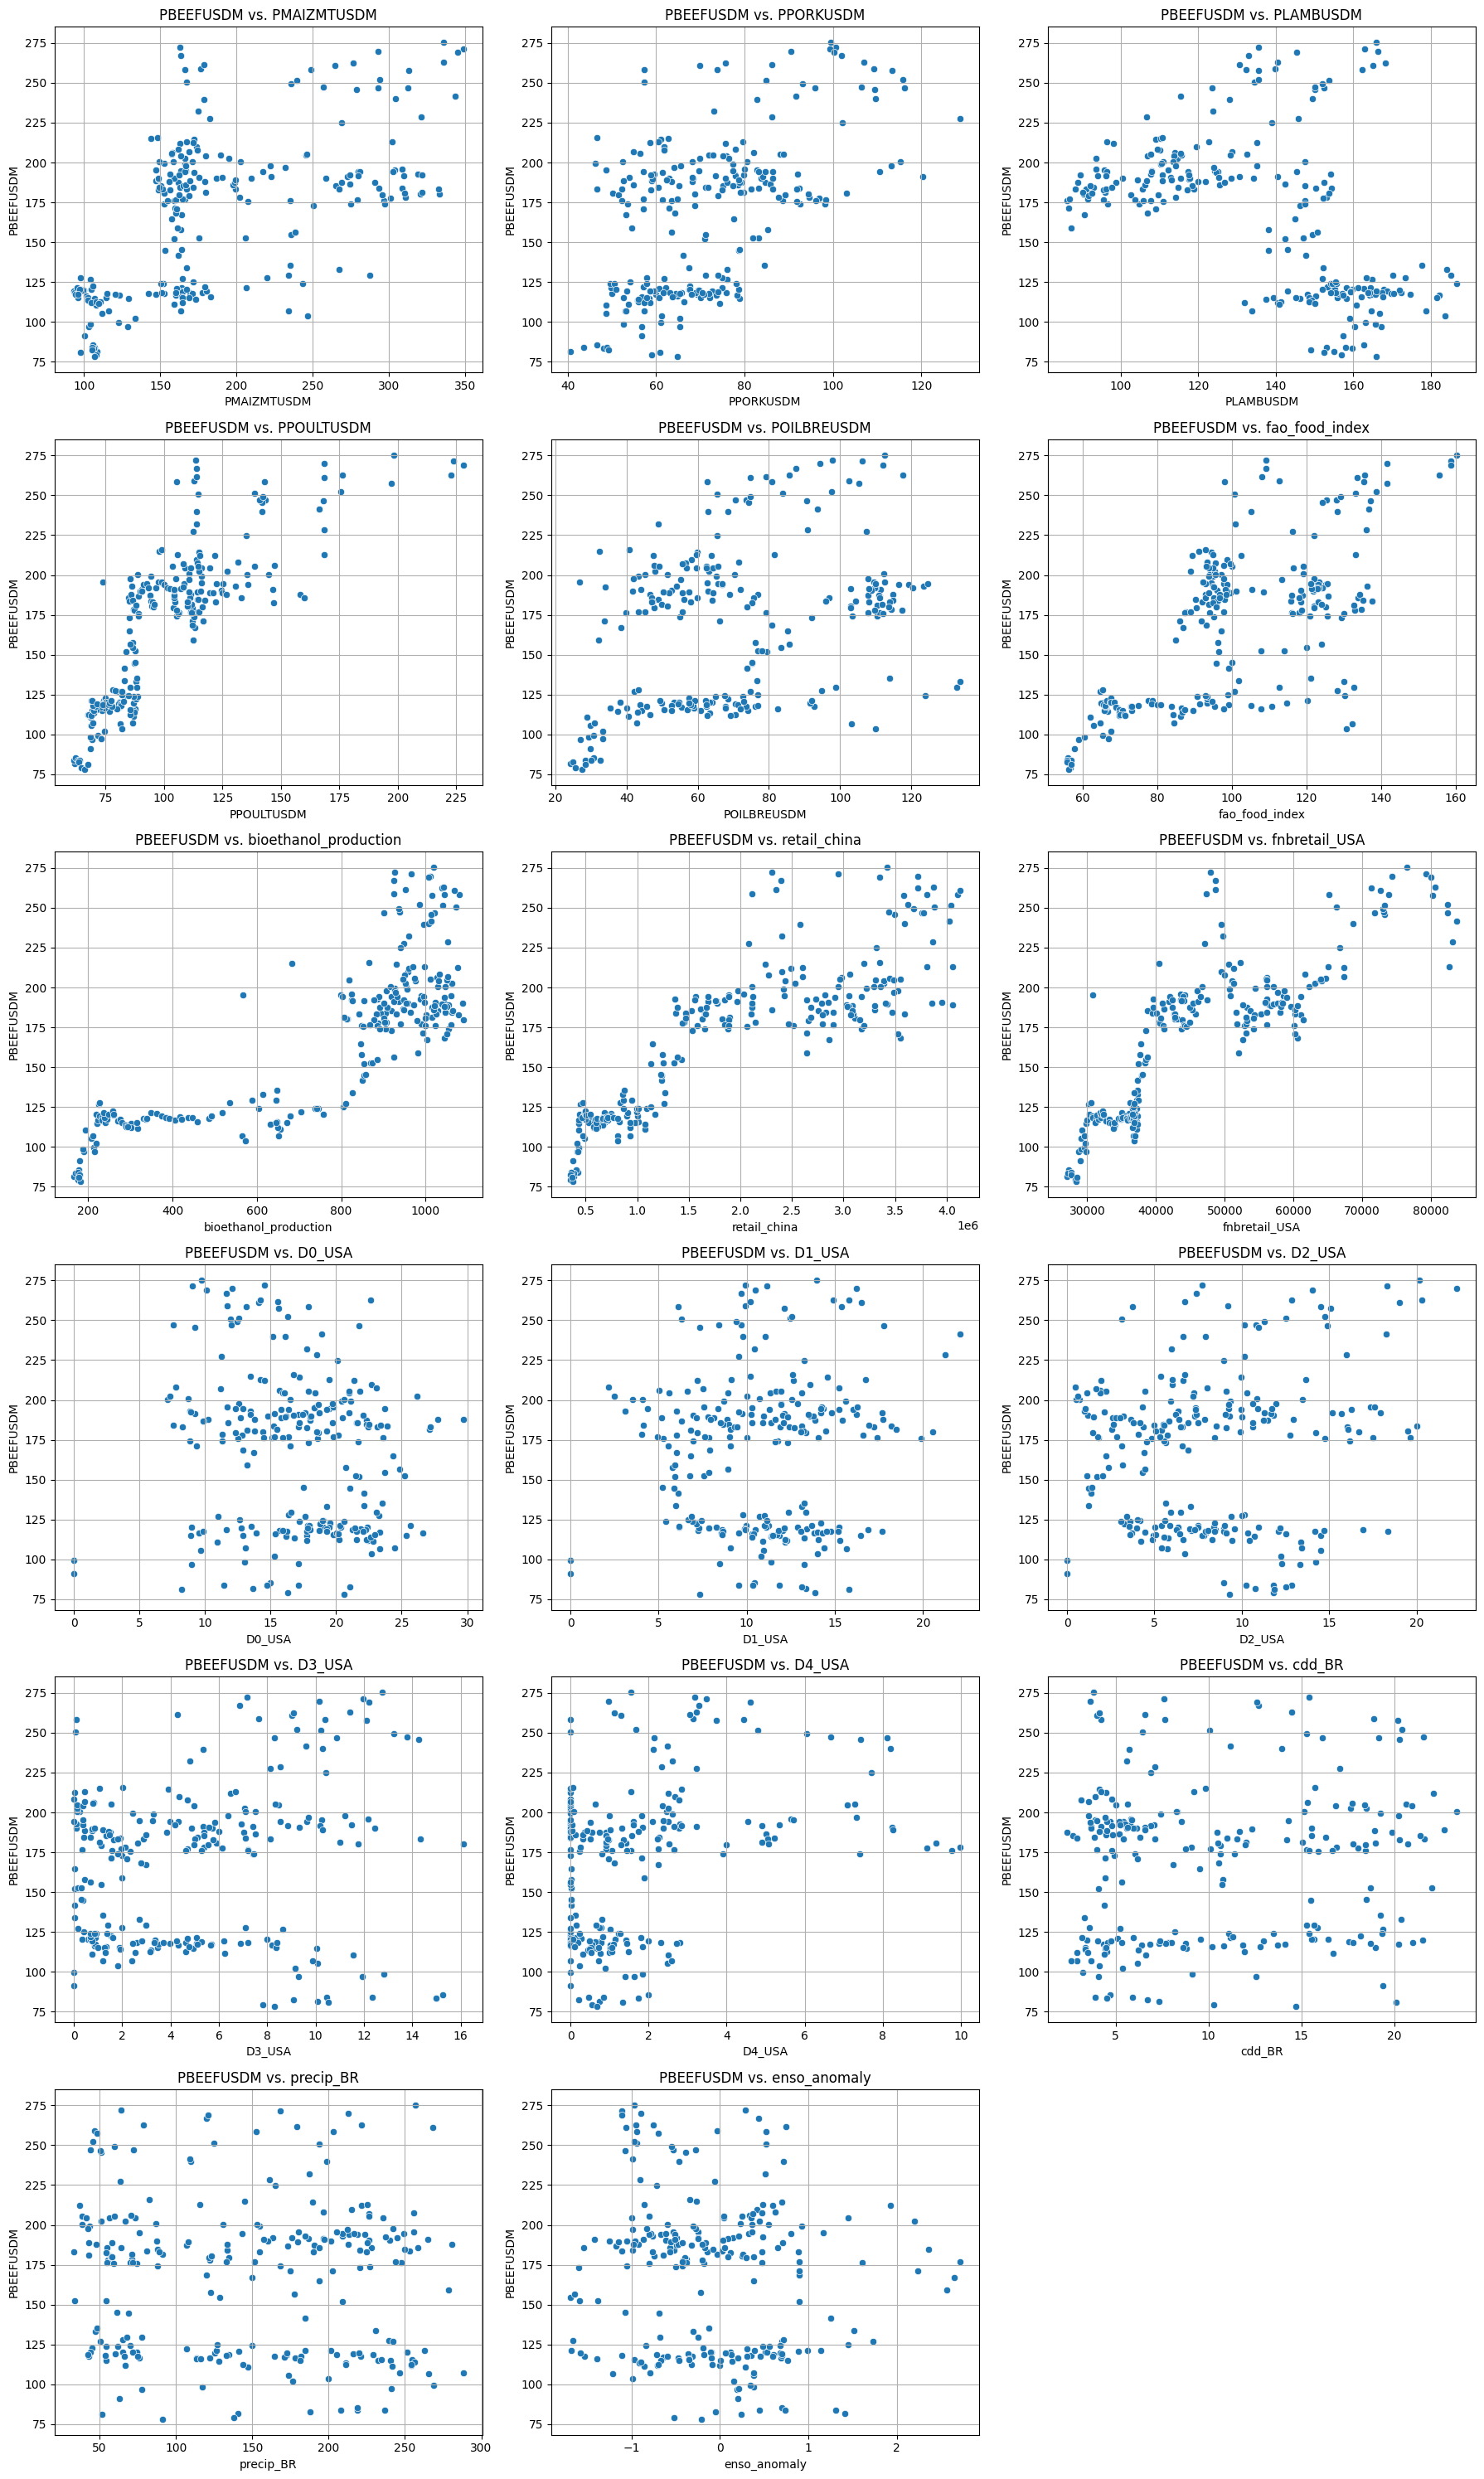

In [90]:
# Scatter plots of original PBEEFUSDM (df_clean) against all other features
print("\n" + "="*100)
print("SCATTER PLOTS: ORIGINAL DATA (df_clean)")
print("="*100)

all_columns = df_clean.columns.tolist()
features_to_plot = [col for col in all_columns if col != 'PBEEFUSDM']

num_features = len(features_to_plot)
rows = int(np.ceil(num_features / 3))  # 3 plots per row
cols = 3

plt.figure(figsize=(18, 5 * rows)) 

for i, feature in enumerate(features_to_plot):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(x=df_clean[feature], y=df_clean['PBEEFUSDM'])
    plt.title(f'PBEEFUSDM vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('PBEEFUSDM')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [91]:
def compute_ffd_weights(d, tau=1e-5):
    """
    Compute weights for fixed-width window fractional differencing.
    Uses the binomial series expansion: w_k = -w_{k-1} * (d - k + 1) / k
    
    Parameters:
    -----------
    d : float
        Differencing order (between 0 and 1)
    tau : float
        Threshold for weight cutoff (default: 1e-5)
    
    Returns:
    --------
    np.array : Array of weights for FFD
    """
    weights = [1.0]
    for k in range(1, 10000):
        w = -weights[-1] * (d - k + 1) / k
        if abs(w) < tau:
            break
        weights.append(w)
    return np.array(weights)

def apply_ffd_to_series(series, d, weights, max_lag=None):
    """
    Apply fractional differencing with fixed-width window.
    Optionally limit maximum window width to reduce data loss.
    
    Parameters:
    -----------
    series : np.array
        The time series data
    d : float
        Differencing order
    weights : np.array
        Precomputed FFD weights
    max_lag : int, optional
        Maximum lag to use (limits window width). If None, uses all weights.
    
    Returns:
    --------
    np.array : Fractionally differenced series
    """
    if np.all(np.isnan(series)):
        return series
    
    # Use max_lag to limit window if specified
    if max_lag is not None:
        weights = weights[:max_lag]
    
    width = len(weights)
    ffd = np.full_like(series, np.nan, dtype=float)
    
    # Apply FFD with fixed window (standard approach)
    for i in range(width - 1, len(series)):
        window = series[i - width + 1:i + 1]
        ffd[i] = np.dot(weights, window)
    
    return ffd

In [92]:
def apply_optimal_fracdiff_min_lag(df_clean, adf_summary_df, alpha=0.05, d_grid=None, tau=1e-5, max_lag_limit=30):
    """
    Apply optimal fractional differencing to non-stationary variables.
    MINIMIZES LAG WINDOW to reduce data loss while maintaining stationarity.
    
    Strategy: For each non-stationary variable, find the MINIMUM d value that achieves
    stationarity using the SMALLEST max_lag that works. This preserves more data.
    
    Parameters:
    -----------
    df_clean : pd.DataFrame
        Input dataframe with all variables
    adf_summary_df : pd.DataFrame
        ADF test results summary
    alpha : float
        Significance level for stationarity (default: 0.05)
    d_grid : np.array
        Grid of d values to search (default: 0 to 1 with 201 points)
    tau : float
        Threshold for weight cutoff
    max_lag_limit : int
        Maximum window width to try (smaller = less data loss, default: 30)
    
    Returns:
    --------
    df_transformed : pd.DataFrame
        Dataframe with transformed variables
    transformation_summary : pd.DataFrame
        Summary of applied transformations
    """
    if d_grid is None:
        d_grid = np.linspace(0, 1, 201)
    
    df_transformed = df_clean.copy()
    transformation_summary = []
    
    for variable in df_clean.columns:
        # Get original series
        series = df_clean[variable].values.astype(float)
        
        # Check if stationary from ADF results
        adf_row = adf_summary_df[adf_summary_df['Variable'] == variable]
        if adf_row.empty:
            print(f"Warning: {variable} not found in ADF results. Keeping as is.")
            transformation_summary.append({
                'Variable': variable,
                'Original Stationary': 'Unknown',
                'Transformation': 'None',
                'Optimal d': None,
                'Max Lag Used': None,
                'Final ADF p-value': None,
                'FFD Weights (full)': None,
                'Data Loss': '0%',
                'Notes': 'Not found in ADF results'
            })
            continue
        
        is_stationary = (adf_row['P-value'].values[0] <= alpha)
        
        if is_stationary:
            # Already stationary, keep as is
            transformation_summary.append({
                'Variable': variable,
                'Original Stationary': 'Yes',
                'Transformation': 'None (d=0)',
                'Optimal d': 0.0,
                'Max Lag Used': 0,
                'Final ADF p-value': adf_row['P-value'].values[0],
                'FFD Weights (full)': 0,
                'Data Loss': '0%',
                'Notes': 'Already stationary'
            })
        else:
            # Find MINIMUM d and MINIMUM max_lag that achieves stationarity
            optimal_d = None
            optimal_max_lag = None
            best_pval = None
            full_weights_count = None
            data_loss_pct = 0
            
            # Try different lag limits from smallest to largest
            for max_lag in range(5, max_lag_limit + 1, 5):
                # For this lag limit, search d_grid
                for d in d_grid:
                    weights = compute_ffd_weights(d, tau=tau)
                    ffd_series = apply_ffd_to_series(series, d, weights, max_lag=max_lag)
                    ffd_clean = ffd_series[~np.isnan(ffd_series)]
                    
                    if len(ffd_clean) < 3:
                        continue
                    
                    try:
                        result = adfuller(ffd_clean, autolag='AIC')
                        pval = result[1]
                        
                        if pval < alpha:
                            optimal_d = d
                            optimal_max_lag = max_lag
                            best_pval = pval
                            full_weights = compute_ffd_weights(d, tau=tau)
                            full_weights_count = len(full_weights)
                            data_loss_pct = (max_lag - 1) / len(series) * 100
                            break  # Found solution with this lag, use it
                    except:
                        continue
                
                # If found solution with this lag limit, don't search larger lags
                if optimal_d is not None:
                    break
            
            if optimal_d is None:
                # If no solution found, use maximum d with minimum required lag
                optimal_d = d_grid[-1]
                
                # Try to find minimum lag that works
                for max_lag in range(5, max_lag_limit + 1, 5):
                    weights = compute_ffd_weights(optimal_d, tau=tau)
                    ffd_series = apply_ffd_to_series(series, optimal_d, weights, max_lag=max_lag)
                    ffd_clean = ffd_series[~np.isnan(ffd_series)]
                    
                    if len(ffd_clean) >= 3:
                        try:
                            result = adfuller(ffd_clean, autolag='AIC')
                            best_pval = result[1]
                            optimal_max_lag = max_lag
                            full_weights = compute_ffd_weights(optimal_d, tau=tau)
                            full_weights_count = len(full_weights)
                            data_loss_pct = (max_lag - 1) / len(series) * 100
                            break
                        except:
                            continue
                
                notes = f"No d found; used max d={optimal_d:.3f} with min viable lag"
            else:
                notes = f"Found optimal d={optimal_d:.3f} with minimum lag"
            
            # Apply the optimal FFD with minimal lag
            weights = compute_ffd_weights(optimal_d, tau=tau)
            df_transformed[variable] = apply_ffd_to_series(series, optimal_d, weights, max_lag=optimal_max_lag)
            
            transformation_summary.append({
                'Variable': variable,
                'Original Stationary': 'No',
                'Transformation': f'FFD (d={optimal_d:.3f})',
                'Optimal d': optimal_d,
                'Max Lag Used': optimal_max_lag,
                'Final ADF p-value': best_pval,
                'FFD Weights (full)': full_weights_count,
                'Data Loss': f'{data_loss_pct:.2f}%',
                'Notes': notes
            })
    
    transformation_summary_df = pd.DataFrame(transformation_summary)
    return df_transformed, transformation_summary_df

In [93]:
# Apply optimal fractional differencing with MINIMAL LAG to minimize data loss
print("\n" + "="*100)
print("APPLYING OPTIMAL FRACTIONAL DIFFERENCING (MINIMAL LAG WINDOW)")
print("="*100)

df_transformed, transformation_summary = apply_optimal_fracdiff_min_lag(
    df_clean, 
    adf_summary_df, 
    alpha=0.05, 
    d_grid=np.linspace(0, 1, 201),
    tau=1e-5,
    max_lag_limit=30  # Limit search to max lag of 30
)

print("\nFractional Differencing Complete!")
print(f"Original shape: {df_clean.shape}")
print(f"Transformed shape (with NaNs): {df_transformed.shape}")

# Drop rows with ANY NaN values to get complete observations only
df_transformed = df_transformed.dropna()
print(f"Final shape (complete rows only): {df_transformed.shape}")

print("\n" + "="*100)
print("TRANSFORMATION SUMMARY (Minimal Lag FFD)")
print("="*100)
display(transformation_summary)


APPLYING OPTIMAL FRACTIONAL DIFFERENCING (MINIMAL LAG WINDOW)

Fractional Differencing Complete!
Original shape: (242, 18)
Transformed shape (with NaNs): (242, 18)
Final shape (complete rows only): (238, 18)

TRANSFORMATION SUMMARY (Minimal Lag FFD)

Fractional Differencing Complete!
Original shape: (242, 18)
Transformed shape (with NaNs): (242, 18)
Final shape (complete rows only): (238, 18)

TRANSFORMATION SUMMARY (Minimal Lag FFD)


,Variable,Original Stationary,Transformation,Optimal d,Max Lag Used,Final ADF p-value,FFD Weights (full),Data Loss,Notes
0,PMAIZMTUSDM,No,FFD (d=0.300),0.300,5,4.672840e-02,2275,1.65%,Found optimal d=0.300 with minimum lag
1,PBEEFUSDM,No,FFD (d=0.760),0.760,5,7.323708e-08,279,1.65%,Found optimal d=0.760 with minimum lag
2,PPORKUSDM,Yes,None (d=0),0.000,0,1.480000e-04,0,0%,Already stationary
3,PLAMBUSDM,No,FFD (d=0.480),0.480,5,4.793510e-02,1015,1.65%,Found optimal d=0.480 with minimum lag
4,PPOULTUSDM,No,FFD (d=0.795),0.795,5,4.927518e-02,234,1.65%,Found optimal d=0.795 with minimum lag
5,POILBREUSDM,Yes,None (d=0),0.000,0,4.610000e-02,0,0%,Already stationary
6,fao_food_index,No,FFD (d=0.505),0.505,5,4.886063e-02,907,1.65%,Found optimal d=0.505 with minimum lag
7,bioethanol_production,No,FFD (d=0.955),0.955,5,2.971378e-02,74,1.65%,Found optimal d=0.955 with minimum lag
8,retail_china,No,FFD (d=0.960),0.960,5,2.469150e-02,69,1.65%,Found optimal d=0.960 with minimum lag
9,fnbretail_USA,No,FFD (d=0.830),0.830,5,4.906070e-02,194,1.65%,Found optimal d=0.830 with minimum lag



SCATTER PLOTS: TRANSFORMED DATA (df_transformed)


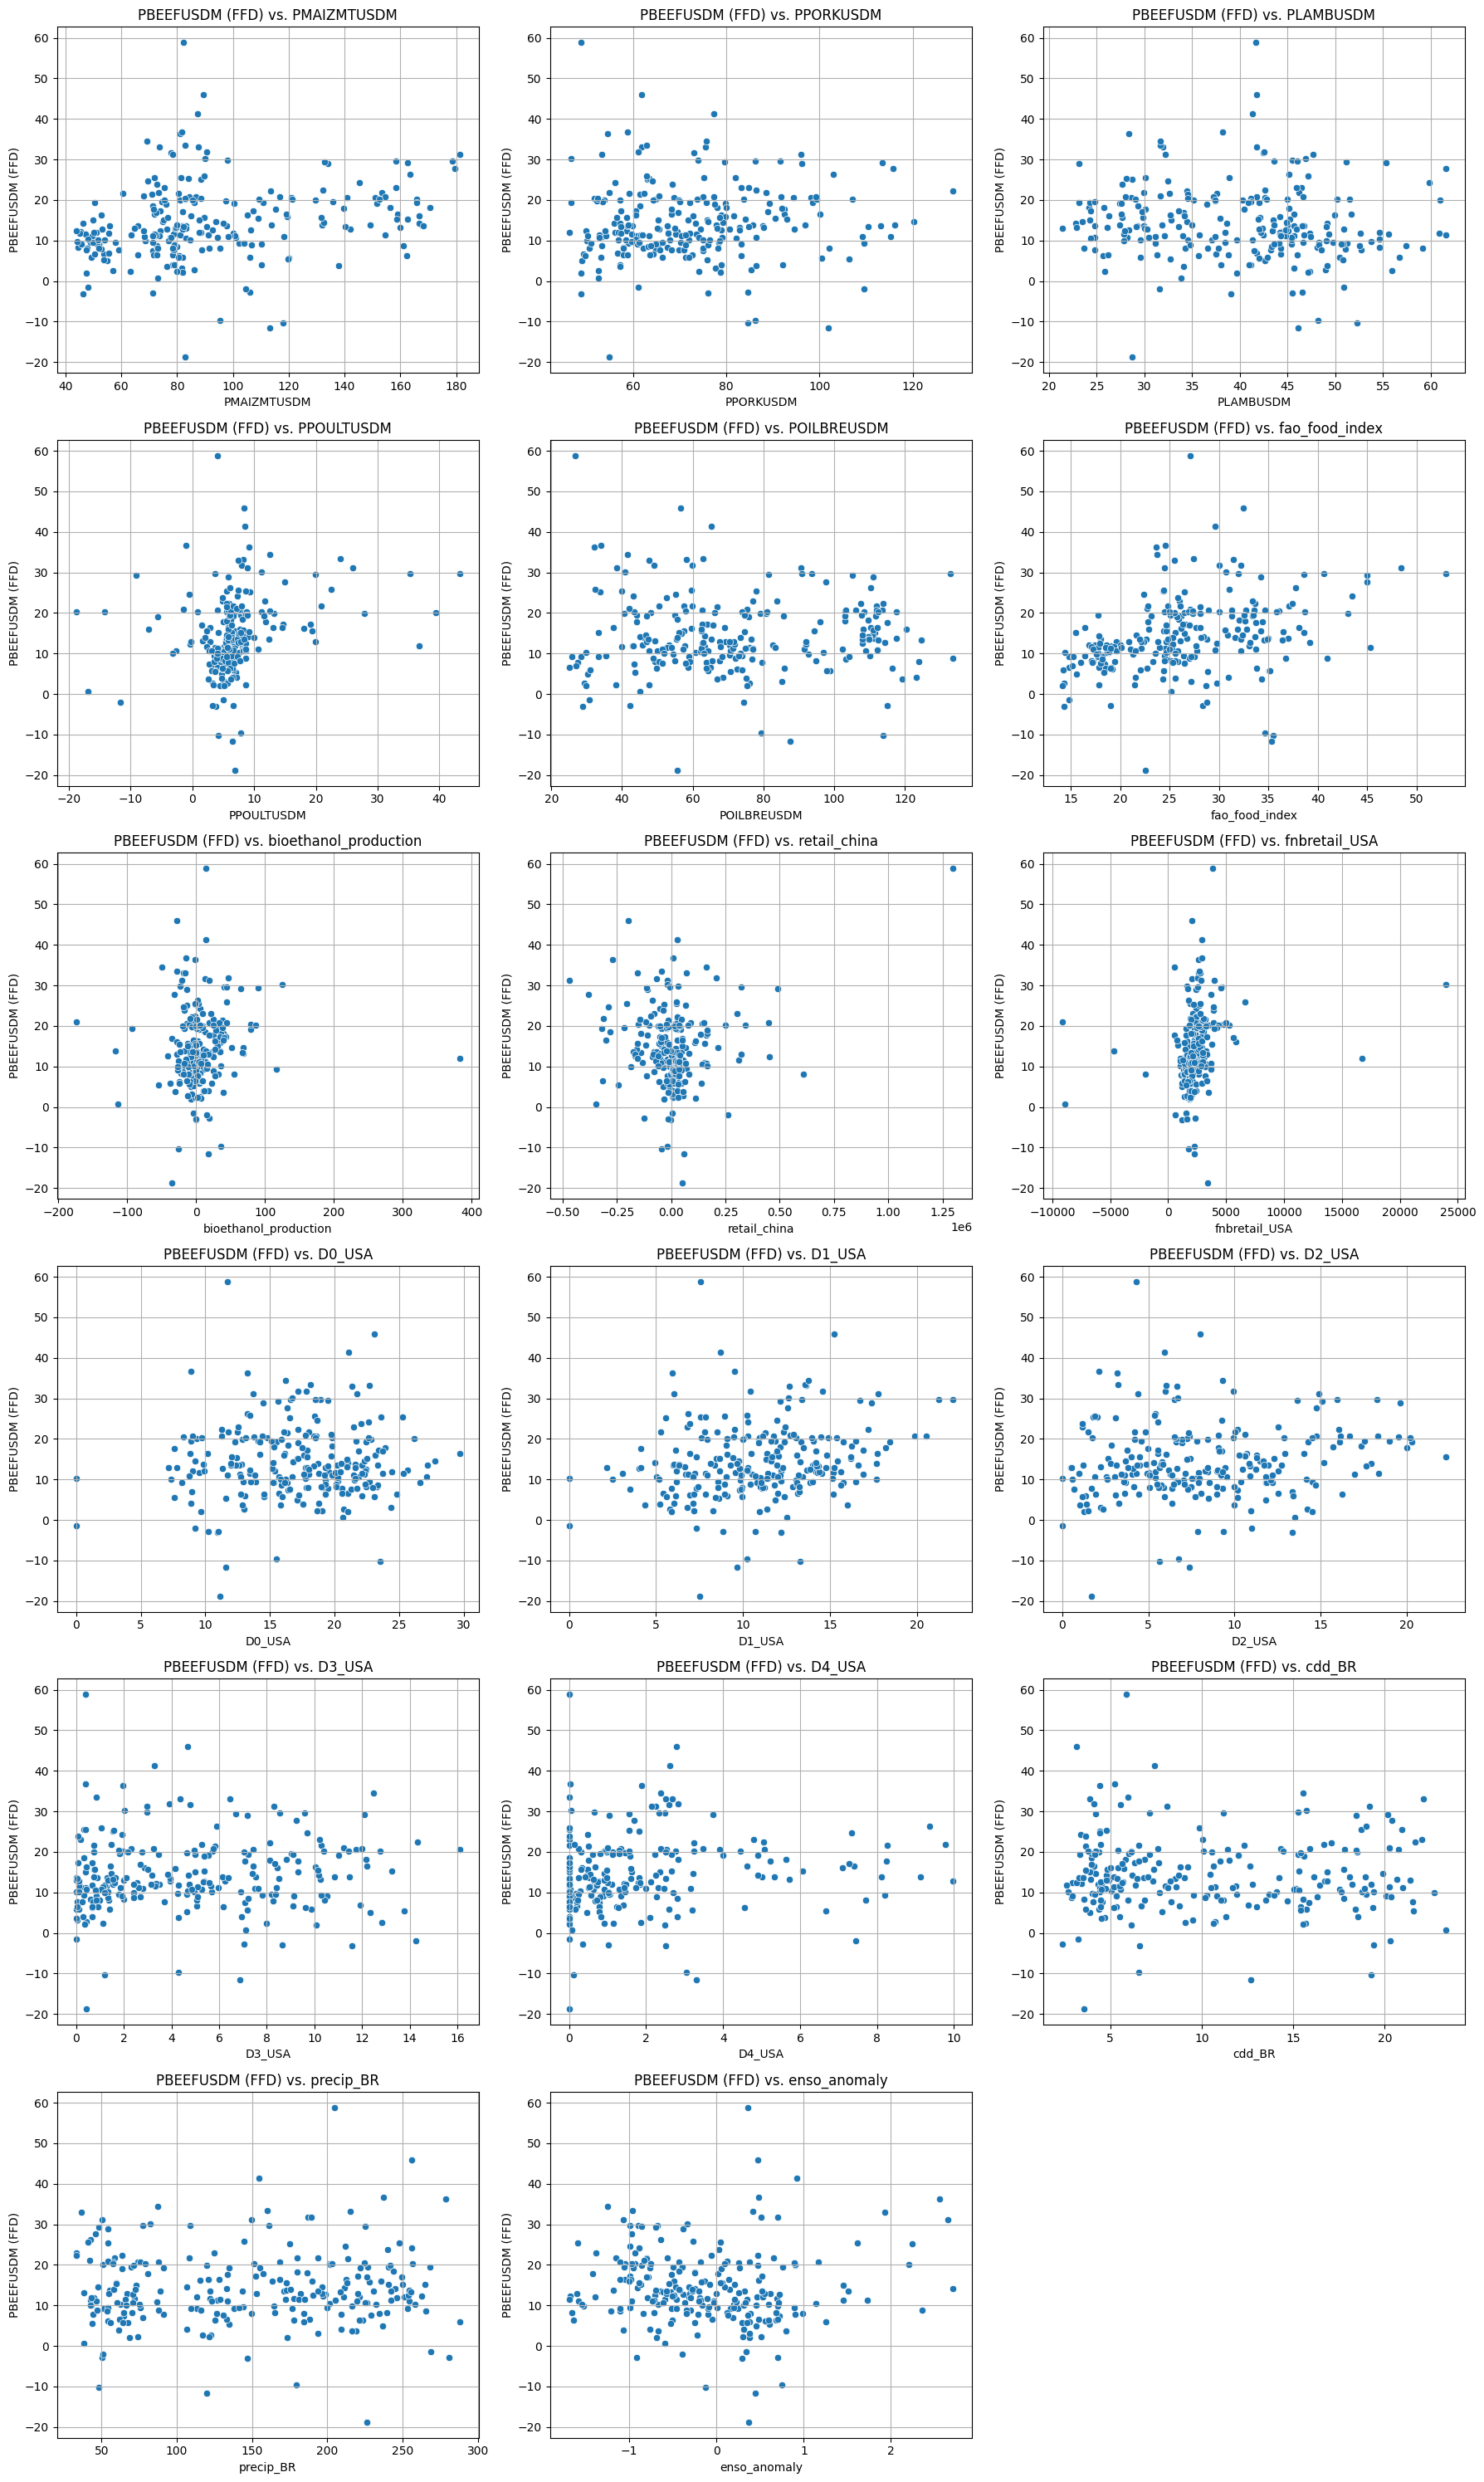

In [94]:
# Scatter plots of transformed PBEEFUSDM (df_transformed) against all other features
print("\n" + "="*100)
print("SCATTER PLOTS: TRANSFORMED DATA (df_transformed)")
print("="*100)

all_columns_transformed = df_transformed.columns.tolist()
features_to_plot_transformed = [col for col in all_columns_transformed if col != 'PBEEFUSDM']

num_features_transformed = len(features_to_plot_transformed)
rows_transformed = int(np.ceil(num_features_transformed / 3))  # 3 plots per row
cols_transformed = 3

plt.figure(figsize=(18, 5 * rows_transformed)) 

for i, feature in enumerate(features_to_plot_transformed):
    plt.subplot(rows_transformed, cols_transformed, i + 1)
    sns.scatterplot(x=df_transformed[feature], y=df_transformed['PBEEFUSDM'])
    plt.title(f'PBEEFUSDM (FFD) vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('PBEEFUSDM (FFD)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [95]:
print("\n" + "="*100)
print("FINAL TRANSFORMED DATA SUMMARY")
print("="*100)

# Data preservation
print("\n📊 DATA PRESERVATION ANALYSIS")
print("-" * 100)
print(f"Original df_clean shape:          {242} rows × {16} columns")
print(f"After FFD (with NaNs):            242 rows × 16 columns")
print(f"Final dataset (complete rows):    {df_transformed.shape[0]} rows × {df_transformed.shape[1]} columns")
print(f"Data retention rate:              {(df_transformed.shape[0] / 242) * 100:.1f}%")

# Detailed missing values analysis
print("\n📍 MISSING VALUES FROM FRACTIONAL DIFFERENCING")
print("-" * 100)
print(f"Total rows lost due to FFD:       {242 - df_transformed.shape[0]} rows")
print(f"Reason: All transformed variables needed max_lag=5, creating 4 NaNs at the start")
print(f"These rows were removed to ensure complete data for regression modeling")

# Summary statistics
print("\n📈 SUMMARY STATISTICS: ORIGINAL vs TRANSFORMED (Complete Observations Only)")
print("-" * 100)
print("\nOriginal Data (df_clean - all 242 rows):\n")
display(df_clean.describe())

print("\nTransformed Data (df_transformed - 238 complete rows):")
display(df_transformed.describe())

# Memory info
print("\n💾 MEMORY FOOTPRINT")
print("-" * 100)
print(f"df_clean memory usage:           {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"df_transformed memory usage:     {df_transformed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Transformation breakdown
print("\n🔄 TRANSFORMATION BREAKDOWN BY VARIABLE TYPE")
print("-" * 100)

stationary_count = transformation_summary['Original Stationary'].value_counts().get('Yes', 0)
transformed_count = (transformation_summary['Original Stationary'] == 'No').sum()

print(f"\nAlready Stationary (unchanged):  {stationary_count} variables")
for idx, row in transformation_summary[transformation_summary['Original Stationary'] == 'Yes'].iterrows():
    print(f"  ✓ {row['Variable']:30} (d=0, no transformation)")

print(f"\nTransformed with Fractional Differencing: {transformed_count} variables")
for idx, row in transformation_summary[transformation_summary['Original Stationary'] == 'No'].iterrows():
    print(f"  ✓ {row['Variable']:30} → d={row['Optimal d']:.3f}, max_lag={row['Max Lag Used']}, data loss: {row['Data Loss']}")

# Date range
print("\n📅 DATA COVERAGE")
print("-" * 100)
print(f"Start date: {df_transformed.index.min()}")
print(f"End date:   {df_transformed.index.max()}")
print(f"Duration:   {(df_transformed.index.max() - df_transformed.index.min()).days / 365.25:.1f} years")
print(f"Observations: {df_transformed.shape[0]} months")

print("\n" + "="*100)
print("✅ DATA READY FOR MODELING")
print("="*100)
print(f"\nFinal dataset shape: {df_transformed.shape}")
print(f"All {df_transformed.shape[1]} variables are now stationary")
print(f"No missing values in final dataset: {df_transformed.isna().any().any() == False}")
print(f"\n✓ Dataset contains {df_transformed.shape[0]} complete monthly observations")
print(f"✓ All variables are stationary (verified by ADF test)")
print(f"✓ Ready for linear regression analysis")


FINAL TRANSFORMED DATA SUMMARY

📊 DATA PRESERVATION ANALYSIS
----------------------------------------------------------------------------------------------------
Original df_clean shape:          242 rows × 16 columns
After FFD (with NaNs):            242 rows × 16 columns
Final dataset (complete rows):    238 rows × 18 columns
Data retention rate:              98.3%

📍 MISSING VALUES FROM FRACTIONAL DIFFERENCING
----------------------------------------------------------------------------------------------------
Total rows lost due to FFD:       4 rows
Reason: All transformed variables needed max_lag=5, creating 4 NaNs at the start
These rows were removed to ensure complete data for regression modeling

📈 SUMMARY STATISTICS: ORIGINAL vs TRANSFORMED (Complete Observations Only)
----------------------------------------------------------------------------------------------------

Original Data (df_clean - all 242 rows):



,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,bioethanol_production,retail_china,fnbretail_USA,D0_USA,D1_USA,D2_USA,D3_USA,D4_USA,cdd_BR,precip_BR,enso_anomaly
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,2.420000e+02,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,188.316069,168.389331,72.104522,134.927993,101.695594,71.249873,99.988843,751.706612,1.933260e+06,46494.847107,17.014174,10.885000,8.215785,4.889793,1.705785,10.222603,147.000702,-0.085537
std,67.223973,48.349486,16.821360,26.345812,29.969954,27.102952,23.752042,304.287701,1.163976e+06,13859.686901,4.975288,3.816214,4.850147,4.026209,2.160655,5.984585,73.263905,0.833040
min,93.415148,78.250000,40.602105,86.119095,61.488636,24.250476,55.900000,166.000000,3.535200e+05,27058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.380000,33.160000,-1.690000
25%,150.702291,119.700000,58.957083,110.918264,80.799513,50.412490,86.775000,487.500000,8.127900e+05,36514.500000,13.440000,8.155000,4.472500,1.277500,0.060000,4.782500,71.082500,-0.700000
50%,166.708197,180.114130,69.867857,140.139116,94.610795,66.560227,96.950000,891.000000,1.834750e+06,42928.000000,17.505000,11.005000,7.440000,4.300000,0.960000,8.310000,149.900000,-0.175000
75%,235.567209,195.421690,81.280574,155.711640,114.214109,93.471769,120.775000,994.500000,3.019950e+06,56118.250000,20.900000,13.365000,11.265000,7.942500,2.447500,15.535000,212.805000,0.447500
max,348.507117,275.304348,128.667727,186.588721,227.963324,133.585217,160.200000,1089.000000,4.126900e+06,83665.000000,29.690000,22.080000,22.270000,16.100000,9.970000,23.340000,288.100000,2.710000



Transformed Data (df_transformed - 238 complete rows):


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,bioethanol_production,retail_china,fnbretail_USA,D0_USA,D1_USA,D2_USA,D3_USA,D4_USA,cdd_BR,precip_BR,enso_anomaly
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,2.380000e+02,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,91.426352,14.279969,72.564170,39.705714,6.813224,71.959792,26.352009,5.899206,5.683892e+03,2356.251180,17.069832,10.884664,8.174034,4.758613,1.712143,10.300042,146.168067,-0.104454
std,34.509132,9.321809,16.575789,9.339699,6.744986,26.761550,7.284583,39.506129,1.560875e+05,2240.932875,4.994964,3.843682,4.876650,3.916425,2.177088,6.002834,73.471014,0.825938
min,43.806038,-18.758285,46.187273,21.392488,-18.838040,25.035000,14.125361,-174.379439,-4.704445e+05,-9149.746328,0.000000,0.000000,0.000000,0.000000,0.000000,2.380000,33.160000,-1.690000
25%,71.314441,9.162676,59.560295,31.683399,4.739582,51.542314,20.905684,-9.072732,-4.816831e+04,1776.092471,13.440000,7.982500,4.455000,1.225000,0.037500,4.792500,70.962500,-0.707500
50%,82.042169,12.937223,70.228696,41.421960,6.053698,67.227543,25.566258,1.387910,5.117395e+03,2137.369692,17.630000,11.035000,7.380000,4.270000,0.960000,8.585000,148.390000,-0.185000
75%,108.538987,19.549618,81.825808,46.092669,7.947349,94.129893,31.578830,18.050737,3.739550e+04,2778.273055,20.975000,13.400000,11.265000,7.517500,2.477500,15.547500,212.465000,0.387500
max,181.321029,58.823467,128.667727,61.590082,43.325106,133.585217,52.993574,382.842721,1.298145e+06,23978.903686,29.690000,22.080000,22.270000,16.100000,9.970000,23.340000,288.100000,2.710000



💾 MEMORY FOOTPRINT
----------------------------------------------------------------------------------------------------
df_clean memory usage:           0.04 MB
df_transformed memory usage:     0.03 MB

🔄 TRANSFORMATION BREAKDOWN BY VARIABLE TYPE
----------------------------------------------------------------------------------------------------

Already Stationary (unchanged):  10 variables
  ✓ PPORKUSDM                      (d=0, no transformation)
  ✓ POILBREUSDM                    (d=0, no transformation)
  ✓ D0_USA                         (d=0, no transformation)
  ✓ D1_USA                         (d=0, no transformation)
  ✓ D2_USA                         (d=0, no transformation)
  ✓ D3_USA                         (d=0, no transformation)
  ✓ D4_USA                         (d=0, no transformation)
  ✓ cdd_BR                         (d=0, no transformation)
  ✓ precip_BR                      (d=0, no transformation)
  ✓ enso_anomaly                   (d=0, no transformation)

Tra

In [97]:

# Export clean and transformed data to CSV
print("\n" + "="*100)
print("EXPORTING DATA TO CSV")
print("="*100)

# Export df_clean
clean_csv_path = "../data/df_clean.csv"
df_clean_export = df_clean.reset_index()
df_clean_export.rename(columns={'date': 'month'}, inplace=True)
df_clean_export.to_csv(clean_csv_path, index=False)
print(f"\n✓ df_clean exported to: {clean_csv_path}")
print(f"  Shape: {df_clean.shape}")
print(f"  Date range: {df_clean.index.min()} to {df_clean.index.max()}")

# Export df_transformed
transformed_csv_path = "../data/df_transformed.csv"
df_transformed_export = df_transformed.reset_index()
df_transformed_export.rename(columns={'date': 'month'}, inplace=True)
df_transformed_export.to_csv(transformed_csv_path, index=False)
print(f"\n✓ df_transformed exported to: {transformed_csv_path}")
print(f"  Shape: {df_transformed.shape}")
print(f"  Date range: {df_transformed.index.min()} to {df_transformed.index.max()}")

print("\n" + "="*100)
print("Data export complete!")
print("="*100)



EXPORTING DATA TO CSV

✓ df_clean exported to: ../data/df_clean.csv
  Shape: (242, 18)
  Date range: 2002-11-01 00:00:00 to 2022-12-01 00:00:00

✓ df_transformed exported to: ../data/df_transformed.csv
  Shape: (238, 18)
  Date range: 2003-03-01 00:00:00 to 2022-12-01 00:00:00

Data export complete!
